# Data Cleaning for League of Legends (LoL) DataSet

In this notebook, we'll do the data cleaning on the LoL dataset based on tier.

In [46]:
#Plotly suffers from an issue where sometimes if you reopen the notebook, the charts are rendered as blank spaces, 
#doing this will help to reload the charts
import plotly.io as pio
pio.renderers.default='notebook'

In [47]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import plotly.express as px
import plotly.graph_objects as go

Our main focus is on the data within 15 minutes of the matches, but we'll take some important parameters such as blue_firstTower, blue_firstBlood as well as tier from the dataset

In [48]:
half_data = pd.read_csv('match_15m.csv')
half_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   matchId         5000 non-null   int64 
 1   blue_kill       5000 non-null   int64 
 2   red_kill        5000 non-null   int64 
 3   blue_gold       5000 non-null   int64 
 4   red_gold        5000 non-null   int64 
 5   blue_tower      5000 non-null   int64 
 6   blue_inhibitor  5000 non-null   int64 
 7   red_tower       5000 non-null   int64 
 8   red_inhibitor   5000 non-null   int64 
 9   blue_monster    5000 non-null   object
 10  red_monster     5000 non-null   object
 11  current_time    5000 non-null   int64 
 12  blue_win        5000 non-null   int64 
dtypes: int64(11), object(2)
memory usage: 507.9+ KB


In [49]:
full_data = pd.read_csv('match_full_time.csv')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   matchId               5000 non-null   int64 
 1   makeTime              5000 non-null   object
 2   tier                  5000 non-null   object
 3   blue_kill             5000 non-null   int64 
 4   red_kill              5000 non-null   int64 
 5   blue_gold             5000 non-null   int64 
 6   red_gold              5000 non-null   int64 
 7   blue_tower            5000 non-null   int64 
 8   blue_inhibitor        5000 non-null   int64 
 9   red_tower             5000 non-null   int64 
 10  red_inhibitor         5000 non-null   int64 
 11  blue_monster          5000 non-null   object
 12  red_monster           5000 non-null   object
 13  blue_firstBlood       5000 non-null   bool  
 14  blue_firstTower       5000 non-null   bool  
 15  blue_firstInhibitor   5000 non-null   

In [50]:
tier_column = full_data['tier']
firstBlood_col = full_data['blue_firstBlood']
firstTower_col = full_data['blue_firstTower']

half_data.insert(1, "tier", tier_column)
half_data.insert(3, "blue_firstBlood", firstBlood_col)
half_data.insert(8, "blue_firstTower", firstTower_col)

'blue_monster' is a list of Epic Monsters killed in a match. But the column itself is not a list. We'll apply ast.literal_eval to convert the column to list 

In [51]:
half_data['blue_monster'].apply(lambda x: isinstance(x , list))

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Name: blue_monster, Length: 5000, dtype: bool

In [52]:
import ast

half_data['blue_monster'] = half_data['blue_monster'].apply(lambda x: ast.literal_eval(x))
half_data['red_monster'] = half_data['red_monster'].apply(lambda x: ast.literal_eval(x))
half_data.head()

,matchId,tier,blue_kill,blue_firstBlood,red_kill,blue_gold,red_gold,blue_tower,blue_firstTower,blue_inhibitor,red_tower,red_inhibitor,blue_monster,red_monster,current_time,blue_win
0,4569533952,BRONZE,7,True,16,20790,26264,0,True,0,0,0,[],[EARTH_DRAGON],900,0
1,4617914371,BRONZE,18,True,9,26615,21469,0,True,0,-1,0,[],"[EARTH_DRAGON, RIFTHERALD]",900,1
2,4624640515,BRONZE,12,True,7,22777,20148,0,True,0,0,0,[],[],900,1
3,4603736070,BRONZE,17,True,9,25239,20929,0,True,0,0,0,[],[],900,1
4,4620294151,BRONZE,15,True,14,24682,23440,0,True,0,0,0,[FIRE_DRAGON],[RIFTHERALD],900,1


In [53]:
half_data['blue_monster'].apply(lambda x: isinstance(x , list))

0       True
1       True
2       True
3       True
4       True
        ... 
4995    True
4996    True
4997    True
4998    True
4999    True
Name: blue_monster, Length: 5000, dtype: bool

In this project, we'll focus on blue team of the match 

In [54]:
blueTeam_data = half_data.copy()

The initial columns for 'blue_tower' and 'red_tower' represented the number of towers destroyed by the enemy team, we created new columns for the number of enemy towers destroyed, and remove the old columns

In [55]:
blue_towers = blueTeam_data['red_tower'].apply(lambda x: 0-x)
red_towers = blueTeam_data['blue_tower'].apply(lambda x: 0-x)

blueTeam_data.insert(7, "blue_towers", blue_towers)
blueTeam_data.insert(9, "red_towers", red_towers)

blueTeam_data.drop(columns = ['blue_tower', 'red_tower'], inplace = True)

We created a function countMonsters to deduce the number of dragons killed for each type of dragon. But in this analysis, we are more interested in seeing how the teams in different tiers benefit from the number of dragons killed, so we add together the dragons. 

In [56]:
def countMonsters(x, monster):
    if(len(x) == 0):
        return 0
    count = 0;
    for i in x:
        if(i == monster):
            count= count + 1 
    return count

In [57]:
blue_monster = blueTeam_data['blue_monster'].tolist()
fire_dragon = pd.DataFrame([countMonsters(x, "FIRE_DRAGON") for x in blue_monster])
water_dragon = pd.DataFrame([countMonsters(x, "WATER_DRAGON") for x in blue_monster])
air_dragon = pd.DataFrame([countMonsters(x, "AIR_DRAGON") for x in blue_monster])
earth_dragon = pd.DataFrame([countMonsters(x, "EARTH_DRAGON") for x in blue_monster])
rift_herald = pd.DataFrame([countMonsters(x, "RIFTHERALD") for x in blue_monster])
#blue_monsters = pd.DataFrame([totalMonsters(x) for x in blue_monster])
dragon_counts = fire_dragon + water_dragon + air_dragon + earth_dragon 


#include first rift herald killed in the dataset
firstRiftHerald = full_data['blue_firstRiftHerald']
#include first dragon killed
firstDragon = full_data['blue_firstDragon']

#blueTeam_data.insert(11, "blue_monsters_count", blue_monsters)
blueTeam_data.insert(11, "blue_firstDragon", firstDragon)
blueTeam_data.insert(12, "blue_firstRiftHerald", firstRiftHerald)
blueTeam_data.insert(13, "rift_herald", rift_herald)
blueTeam_data.insert(14, "dragons_count", dragon_counts)

blueTeam_data.insert(15, "fire_dragon", fire_dragon)
blueTeam_data.insert(16, "water_dragon", water_dragon)
blueTeam_data.insert(17, "air_dragon", air_dragon)
blueTeam_data.insert(18, "earth_dragon", earth_dragon)

blueTeam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   matchId               5000 non-null   int64 
 1   tier                  5000 non-null   object
 2   blue_kill             5000 non-null   int64 
 3   blue_firstBlood       5000 non-null   bool  
 4   red_kill              5000 non-null   int64 
 5   blue_gold             5000 non-null   int64 
 6   red_gold              5000 non-null   int64 
 7   blue_towers           5000 non-null   int64 
 8   red_towers            5000 non-null   int64 
 9   blue_firstTower       5000 non-null   bool  
 10  blue_inhibitor        5000 non-null   int64 
 11  blue_firstDragon      5000 non-null   bool  
 12  blue_firstRiftHerald  5000 non-null   bool  
 13  rift_herald           5000 non-null   int64 
 14  dragons_count         5000 non-null   int64 
 15  fire_dragon           5000 non-null   

In [58]:
blueTeam_data.replace({False: 0, True: 1}, inplace=True)

The below function is used to find the first dragon killed if the blue team secures the first dragon in the first 15 minutes

Think about how teams prioritize dragons e.g. if the first dragon is ocean dragon, what is the team's decision?

How to tell is a dragon is prioritized or not? use blue_firsDragon to find out if blue gets the first dragon, then go to blue_monsters to select the first dragon appeared in the list, finally create a new column called first_dragon killed

In [59]:
def findFirstDragon(isFirstDragon, monsters):
    count = 0
    if isFirstDragon == 1: 
        for monster in monsters:
            if "DRAGON" in monster:
                return monster
    return None

In [60]:
firstDragon = blueTeam_data[["blue_firstDragon", "blue_monster"]].apply(lambda x: findFirstDragon(x[0], x[1]), axis=1)
blueTeam_data.insert(12, "first_dragon", firstDragon)

In [61]:
blueTeam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   matchId               5000 non-null   int64 
 1   tier                  5000 non-null   object
 2   blue_kill             5000 non-null   int64 
 3   blue_firstBlood       5000 non-null   int64 
 4   red_kill              5000 non-null   int64 
 5   blue_gold             5000 non-null   int64 
 6   red_gold              5000 non-null   int64 
 7   blue_towers           5000 non-null   int64 
 8   red_towers            5000 non-null   int64 
 9   blue_firstTower       5000 non-null   int64 
 10  blue_inhibitor        5000 non-null   int64 
 11  blue_firstDragon      5000 non-null   int64 
 12  first_dragon          2275 non-null   object
 13  blue_firstRiftHerald  5000 non-null   int64 
 14  rift_herald           5000 non-null   int64 
 15  dragons_count         5000 non-null   

Remove the columns that are not relevant to our analysis 

In [62]:
# blueTeam_data.drop(columns = ['matchId', 'current_time', 'red_kill','red_gold','red_monster', 'blue_monster'], inplace = True)
# DID NOT INCLUDE: red_gold
blueTeam_data.drop(columns = ['matchId', 'current_time', 'red_kill','red_monster', 'blue_monster'], inplace = True)

In [63]:
blueTeam_data[blueTeam_data['red_inhibitor'] != 0]

,tier,blue_kill,blue_firstBlood,blue_gold,red_gold,blue_towers,red_towers,blue_firstTower,blue_inhibitor,blue_firstDragon,first_dragon,blue_firstRiftHerald,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,red_inhibitor,blue_win
63,BRONZE,10,1,26259,20272,5,0,1,0,1,EARTH_DRAGON,1,1,2,0,1,0,1,-1,1
257,BRONZE,20,1,24757,22362,3,0,1,0,1,AIR_DRAGON,1,1,1,0,0,1,0,-1,1
648,BRONZE,20,1,29790,13908,7,0,1,0,1,AIR_DRAGON,1,1,1,0,0,1,0,-1,1
847,BRONZE,6,1,20590,11071,6,0,1,0,0,None,1,1,0,0,0,0,0,-1,1
954,BRONZE,18,1,29519,18252,5,0,1,0,1,FIRE_DRAGON,1,1,1,1,0,0,0,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,DIAMOND,12,1,25788,13287,7,0,1,0,1,EARTH_DRAGON,1,1,1,0,0,0,1,-1,1
4957,DIAMOND,19,1,28707,14696,6,0,1,0,0,None,1,1,0,0,0,0,0,-1,1
4964,DIAMOND,9,1,23371,12660,6,0,1,0,1,AIR_DRAGON,1,1,1,0,0,1,0,-1,1
4976,DIAMOND,20,1,28316,18754,6,0,1,0,1,EARTH_DRAGON,1,1,1,0,0,0,1,-1,1


In [64]:
blueTeam_data[blueTeam_data['blue_inhibitor'] != 0]

,tier,blue_kill,blue_firstBlood,blue_gold,red_gold,blue_towers,red_towers,blue_firstTower,blue_inhibitor,blue_firstDragon,first_dragon,blue_firstRiftHerald,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,red_inhibitor,blue_win
106,BRONZE,4,1,16159,27080,0,4,0,-1,0,None,0,0,0,0,0,0,0,0,0
258,BRONZE,4,0,16371,30568,0,7,0,-1,0,None,0,0,0,0,0,0,0,0,0
541,BRONZE,2,1,13081,26784,0,4,0,-1,0,None,0,0,0,0,0,0,0,0,0
712,BRONZE,3,1,17466,32085,0,8,0,-2,0,None,0,0,0,0,0,0,0,0,0
729,BRONZE,1,0,14685,30526,0,9,0,-2,0,None,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933,DIAMOND,5,1,13157,20767,0,5,0,-1,0,None,0,0,0,0,0,0,0,0,0
4940,DIAMOND,2,0,14979,27423,0,8,0,-1,0,None,0,0,0,0,0,0,0,0,0
4963,DIAMOND,3,0,15675,26260,0,6,0,-1,0,None,0,0,0,0,0,0,0,0,0
4981,DIAMOND,7,0,20364,27506,1,6,0,-1,0,None,0,0,0,0,0,0,0,0,0


To be fair for our analysis, we are going to remove rows with either blue_inhibitor or red_inhibitor not equals 0. Inhibitors takedowns in 15 minutes are unusual, which occur with trolling or afk players 

In [65]:
outlier_rows = blueTeam_data.loc[(blueTeam_data['blue_inhibitor'] != 0) | (blueTeam_data['red_inhibitor'] != 0)]
blueTeam_data.drop(outlier_rows.index, inplace = True)
print("Number of (inhibitor)outlier dropped = {}".format(outlier_rows.shape[0]))

Number of (inhibitor)outlier dropped = 138


Matches with more than 3 towers destroyed are also unusual (happens when a team has a huge lead due to troll/AFK), hence we drop them too

In [66]:
outlier_rows = blueTeam_data.loc[(blueTeam_data['blue_towers']>3) | (blueTeam_data['red_towers']>3)]
blueTeam_data.drop(outlier_rows.index, inplace = True)
print("Number of (towers)outlier dropped = {}".format(outlier_rows.shape[0]))

Number of (towers)outlier dropped = 74


In [67]:
blueTeam_data.reset_index(drop=True, inplace = True)
blueTeam_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tier                  4788 non-null   object
 1   blue_kill             4788 non-null   int64 
 2   blue_firstBlood       4788 non-null   int64 
 3   blue_gold             4788 non-null   int64 
 4   red_gold              4788 non-null   int64 
 5   blue_towers           4788 non-null   int64 
 6   red_towers            4788 non-null   int64 
 7   blue_firstTower       4788 non-null   int64 
 8   blue_inhibitor        4788 non-null   int64 
 9   blue_firstDragon      4788 non-null   int64 
 10  first_dragon          2194 non-null   object
 11  blue_firstRiftHerald  4788 non-null   int64 
 12  rift_herald           4788 non-null   int64 
 13  dragons_count         4788 non-null   int64 
 14  fire_dragon           4788 non-null   int64 
 15  water_dragon          4788 non-null   

Gold Difference between blue and red team:

In [68]:
gold_diff = blueTeam_data['blue_gold'] - blueTeam_data['red_gold']
blueTeam_data.insert(12, "gold_diff", gold_diff)

Further drop irrelevant columns

In [69]:
# ADDED HERE AFTER CALCULATING GOLD DIFF: red_gold
blueTeam_data.drop(columns = ['blue_inhibitor', 'red_inhibitor', 'red_towers', 'red_gold'], inplace = True)

In [70]:
bronze_data = pd.DataFrame(blueTeam_data[blueTeam_data['tier'] == 'BRONZE'])
silver_data = pd.DataFrame(blueTeam_data[blueTeam_data['tier'] == 'SILVER'])
gold_data = pd.DataFrame(blueTeam_data[blueTeam_data['tier'] == 'GOLD'])
platinum_data = pd.DataFrame(blueTeam_data[blueTeam_data['tier'] == 'PLATINUM'])
diamond_data = pd.DataFrame(blueTeam_data[blueTeam_data['tier'] == 'DIAMOND'])

In [71]:
# DELETE THIS 
blueTeam_data

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
0,BRONZE,7,1,20790,0,1,0,None,1,-5474,0,0,0,0,0,0,0
1,BRONZE,18,1,26615,1,1,0,None,0,5146,0,0,0,0,0,0,1
2,BRONZE,12,1,22777,0,1,1,None,0,2629,0,0,0,0,0,0,1
3,BRONZE,17,1,25239,0,1,1,None,1,4310,0,0,0,0,0,0,1
4,BRONZE,15,1,24682,0,1,1,FIRE_DRAGON,0,1242,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4783,DIAMOND,3,0,19794,0,0,0,None,0,-8587,0,0,0,0,0,0,0
4784,DIAMOND,8,0,22266,0,0,0,None,1,-7539,1,0,0,0,0,0,0
4785,DIAMOND,9,0,25308,1,0,0,None,1,-1028,1,1,0,1,0,0,1
4786,DIAMOND,5,1,21922,0,0,1,WATER_DRAGON,0,52,0,1,0,1,0,0,0


Drop outlier kills because generally, if the enemy team gives up early, they will give away kills, leading to early defeat.

In [72]:
blue_kill = bronze_data['blue_kill']

q1 = blue_kill.quantile(0.25)
q3 = blue_kill.quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)

bronze_data.loc[blue_kill > upper_bound]

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
105,BRONZE,25,1,26166,1,1,1,AIR_DRAGON,0,8624,0,2,0,0,1,1,1
136,BRONZE,25,1,30651,3,1,1,EARTH_DRAGON,1,12092,1,2,0,1,0,1,1
218,BRONZE,20,1,25810,0,1,1,FIRE_DRAGON,1,1937,1,1,1,0,0,0,1
228,BRONZE,20,1,27471,0,1,1,AIR_DRAGON,1,5564,1,1,0,0,1,0,1
234,BRONZE,20,1,26289,0,1,1,EARTH_DRAGON,1,3734,1,2,0,1,0,1,1
262,BRONZE,22,1,26845,0,1,1,WATER_DRAGON,1,7650,0,1,0,1,0,0,1
282,BRONZE,20,1,25577,0,1,1,FIRE_DRAGON,1,3965,1,1,1,0,0,0,1
338,BRONZE,20,1,27276,0,1,1,FIRE_DRAGON,1,6337,1,1,1,0,0,0,1
386,BRONZE,20,1,28264,3,1,0,None,1,7320,1,0,0,0,0,0,1
397,BRONZE,20,1,28627,2,1,1,FIRE_DRAGON,1,7383,1,2,1,0,0,1,1


In [73]:
outlier_rows = bronze_data.loc[blue_kill > upper_bound]
bronze_data.drop(outlier_rows.index, inplace = True)
print("Number of outlier dropped for Bronze = {}".format(outlier_rows.shape[0]))

Number of outlier dropped for Bronze = 27


In [74]:
blue_kill = silver_data['blue_kill']

q1 = blue_kill.quantile(0.25)
q3 = blue_kill.quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)

silver_data.loc[blue_kill > upper_bound]

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
1077,SILVER,20,1,27508,0,1,1,WATER_DRAGON,1,7756,1,1,0,1,0,0,1
1083,SILVER,22,0,31072,3,1,1,FIRE_DRAGON,0,11062,0,2,1,1,0,0,1
1087,SILVER,20,1,30103,2,1,1,EARTH_DRAGON,1,9040,0,1,0,0,0,1,1
1112,SILVER,23,1,26427,0,1,1,FIRE_DRAGON,1,3825,0,1,1,0,0,0,1
1121,SILVER,24,0,29731,1,0,1,FIRE_DRAGON,1,124,0,1,1,0,0,0,1
1176,SILVER,21,1,29133,1,1,1,FIRE_DRAGON,0,7384,0,1,1,0,0,0,0
1192,SILVER,22,0,28667,1,1,1,AIR_DRAGON,1,8215,1,2,0,0,1,1,1
1211,SILVER,20,0,25576,0,0,0,None,0,2199,0,1,0,0,0,1,1
1227,SILVER,22,1,28680,1,1,1,EARTH_DRAGON,1,4746,0,1,0,0,0,1,1
1281,SILVER,24,1,31419,3,1,1,WATER_DRAGON,0,13964,0,1,0,1,0,0,1


In [75]:
outlier_rows = silver_data.loc[blue_kill > upper_bound]
silver_data.drop(outlier_rows.index, inplace = True)
print("Number of outlier dropped for Silver = {}".format(outlier_rows.shape[0]))

Number of outlier dropped for Silver = 21


In [76]:
blue_kill = gold_data['blue_kill']

q1 = blue_kill.quantile(0.25)
q3 = blue_kill.quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)
gold_data.loc[blue_kill > upper_bound]

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
1979,GOLD,25,1,31774,2,1,1,EARTH_DRAGON,1,9400,1,2,0,1,0,1,1
2009,GOLD,23,1,28478,1,1,1,WATER_DRAGON,0,7124,0,1,0,1,0,0,0
2278,GOLD,23,1,31368,2,1,1,WATER_DRAGON,1,9495,1,1,0,1,0,0,1
2364,GOLD,24,1,31176,2,1,1,FIRE_DRAGON,1,11769,1,1,1,0,0,0,1
2525,GOLD,24,0,29568,1,1,1,EARTH_DRAGON,0,9295,0,2,0,1,0,1,1
2897,GOLD,25,0,33093,3,1,1,WATER_DRAGON,1,8770,1,2,0,1,1,0,1
2899,GOLD,27,1,32300,2,1,1,AIR_DRAGON,0,11047,0,1,0,0,1,0,1


In [77]:
outlier_rows = gold_data.loc[blue_kill > upper_bound]
gold_data.drop(outlier_rows.index, inplace = True)
print("Number of outlier dropped for Gold = {}".format(outlier_rows.shape[0]))

Number of outlier dropped for Gold = 7


In [78]:
blue_kill = platinum_data['blue_kill']

q1 = blue_kill.quantile(0.25)
q3 = blue_kill.quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)

platinum_data.loc[blue_kill > upper_bound]

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
3127,PLATINUM,29,1,29910,1,1,0,None,0,5151,0,0,0,0,0,0,0
3200,PLATINUM,24,0,29143,1,1,0,None,1,4130,0,0,0,0,0,0,1
3419,PLATINUM,23,1,29951,3,1,0,None,1,8099,1,1,0,0,0,1,1
3489,PLATINUM,24,1,32769,3,1,1,FIRE_DRAGON,1,11783,1,1,1,0,0,0,1
3689,PLATINUM,23,1,30399,2,1,1,AIR_DRAGON,1,3999,1,2,1,0,1,0,1
3758,PLATINUM,26,0,31205,2,1,1,WATER_DRAGON,1,5881,1,1,0,1,0,0,1


In [79]:
outlier_rows = platinum_data.loc[blue_kill > upper_bound]
platinum_data.drop(outlier_rows.index, inplace = True)
print("Number of outlier dropped for Platinum = {}".format(outlier_rows.shape[0]))

Number of outlier dropped for Platinum = 6


In [80]:
blue_kill = diamond_data['blue_kill']

q1 = blue_kill.quantile(0.25)
q3 = blue_kill.quantile(0.75)

iqr = q3 - q1

upper_bound = q3 + (1.5 * iqr)

diamond_data.loc[blue_kill > upper_bound]

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
3913,DIAMOND,25,1,29515,1,1,0,None,1,3594,1,0,0,0,0,0,1
3925,DIAMOND,24,0,31532,2,1,0,None,1,6089,1,0,0,0,0,0,1
3928,DIAMOND,26,1,28707,1,1,0,None,1,9316,0,0,0,0,0,0,1
3948,DIAMOND,24,0,30328,2,0,1,FIRE_DRAGON,1,1649,1,1,1,0,0,0,0
4337,DIAMOND,26,1,32440,2,1,1,AIR_DRAGON,1,9530,1,2,0,1,1,0,1
4431,DIAMOND,25,1,28995,0,0,0,None,0,974,0,0,0,0,0,0,1
4437,DIAMOND,24,0,30975,2,1,1,FIRE_DRAGON,1,9873,0,1,1,0,0,0,1
4540,DIAMOND,27,1,30244,1,1,1,EARTH_DRAGON,1,5593,1,1,0,0,0,1,1


In [81]:
outlier_rows = diamond_data.loc[blue_kill > upper_bound]
diamond_data.drop(outlier_rows.index, inplace = True)
print("Number of outlier dropped for Diamond = {}".format(outlier_rows.shape[0]))

Number of outlier dropped for Diamond = 8


In [82]:
blueTeam_cleaned_data = bronze_data.append(silver_data, ignore_index = True)

C:\Users\Michael Poon\AppData\Local\Temp\ipykernel_13292\540993495.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [83]:
blueTeam_cleaned_data = blueTeam_cleaned_data.append(gold_data, ignore_index = True)

C:\Users\Michael Poon\AppData\Local\Temp\ipykernel_13292\3771925729.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [84]:
blueTeam_cleaned_data = blueTeam_cleaned_data.append(platinum_data, ignore_index = True)

C:\Users\Michael Poon\AppData\Local\Temp\ipykernel_13292\4193442038.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [85]:
blueTeam_cleaned_data = blueTeam_cleaned_data.append(diamond_data, ignore_index = True)

C:\Users\Michael Poon\AppData\Local\Temp\ipykernel_13292\957181105.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [86]:
blueTeam_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4719 entries, 0 to 4718
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tier                  4719 non-null   object
 1   blue_kill             4719 non-null   int64 
 2   blue_firstBlood       4719 non-null   int64 
 3   blue_gold             4719 non-null   int64 
 4   blue_towers           4719 non-null   int64 
 5   blue_firstTower       4719 non-null   int64 
 6   blue_firstDragon      4719 non-null   int64 
 7   first_dragon          2142 non-null   object
 8   blue_firstRiftHerald  4719 non-null   int64 
 9   gold_diff             4719 non-null   int64 
 10  rift_herald           4719 non-null   int64 
 11  dragons_count         4719 non-null   int64 
 12  fire_dragon           4719 non-null   int64 
 13  water_dragon          4719 non-null   int64 
 14  air_dragon            4719 non-null   int64 
 15  earth_dragon          4719 non-null   

In [87]:
blueTeam_cleaned_data

,tier,blue_kill,blue_firstBlood,blue_gold,blue_towers,blue_firstTower,blue_firstDragon,first_dragon,blue_firstRiftHerald,gold_diff,rift_herald,dragons_count,fire_dragon,water_dragon,air_dragon,earth_dragon,blue_win
0,BRONZE,7,1,20790,0,1,0,None,1,-5474,0,0,0,0,0,0,0
1,BRONZE,18,1,26615,1,1,0,None,0,5146,0,0,0,0,0,0,1
2,BRONZE,12,1,22777,0,1,1,None,0,2629,0,0,0,0,0,0,1
3,BRONZE,17,1,25239,0,1,1,None,1,4310,0,0,0,0,0,0,1
4,BRONZE,15,1,24682,0,1,1,FIRE_DRAGON,0,1242,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4714,DIAMOND,3,0,19794,0,0,0,None,0,-8587,0,0,0,0,0,0,0
4715,DIAMOND,8,0,22266,0,0,0,None,1,-7539,1,0,0,0,0,0,0
4716,DIAMOND,9,0,25308,1,0,0,None,1,-1028,1,1,0,1,0,0,1
4717,DIAMOND,5,1,21922,0,0,1,WATER_DRAGON,0,52,0,1,0,1,0,0,0


In [88]:
#blueTeam_cleaned_data.to_csv('blueTeam_cleaned_data.csv')

Text(0.5, 1.0, 'gold_diff vs blue_win')

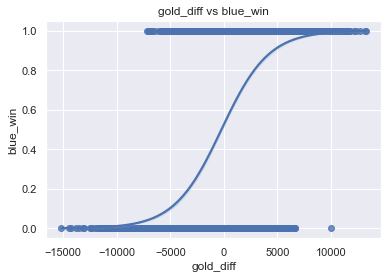

In [89]:
sb.regplot(x= 'gold_diff', y= 'blue_win', data= blueTeam_cleaned_data, logistic= True).set_title('gold_diff vs blue_win')

Text(0.5, 1.0, 'blue_kill vs blue_win')

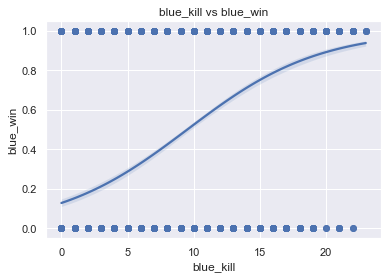

In [90]:
sb.regplot(x= 'blue_kill', y= 'blue_win', data= blueTeam_cleaned_data, logistic= True).set_title('blue_kill vs blue_win')